In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import scipy
from scipy.optimize import minimize
from lmfit import Model
from IPython.display import display
import sys
MODULE_FULL_PATH = '/Users/andrewproppe/Bawendi_Lab/python/g2_fitting/'
sys.path.insert(1, MODULE_FULL_PATH)
import MAP_funcs as MAP

def find_nearest(value, array):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def g2_func(x, w):
    return eval(funk)

<IPython.core.display.Javascript object>


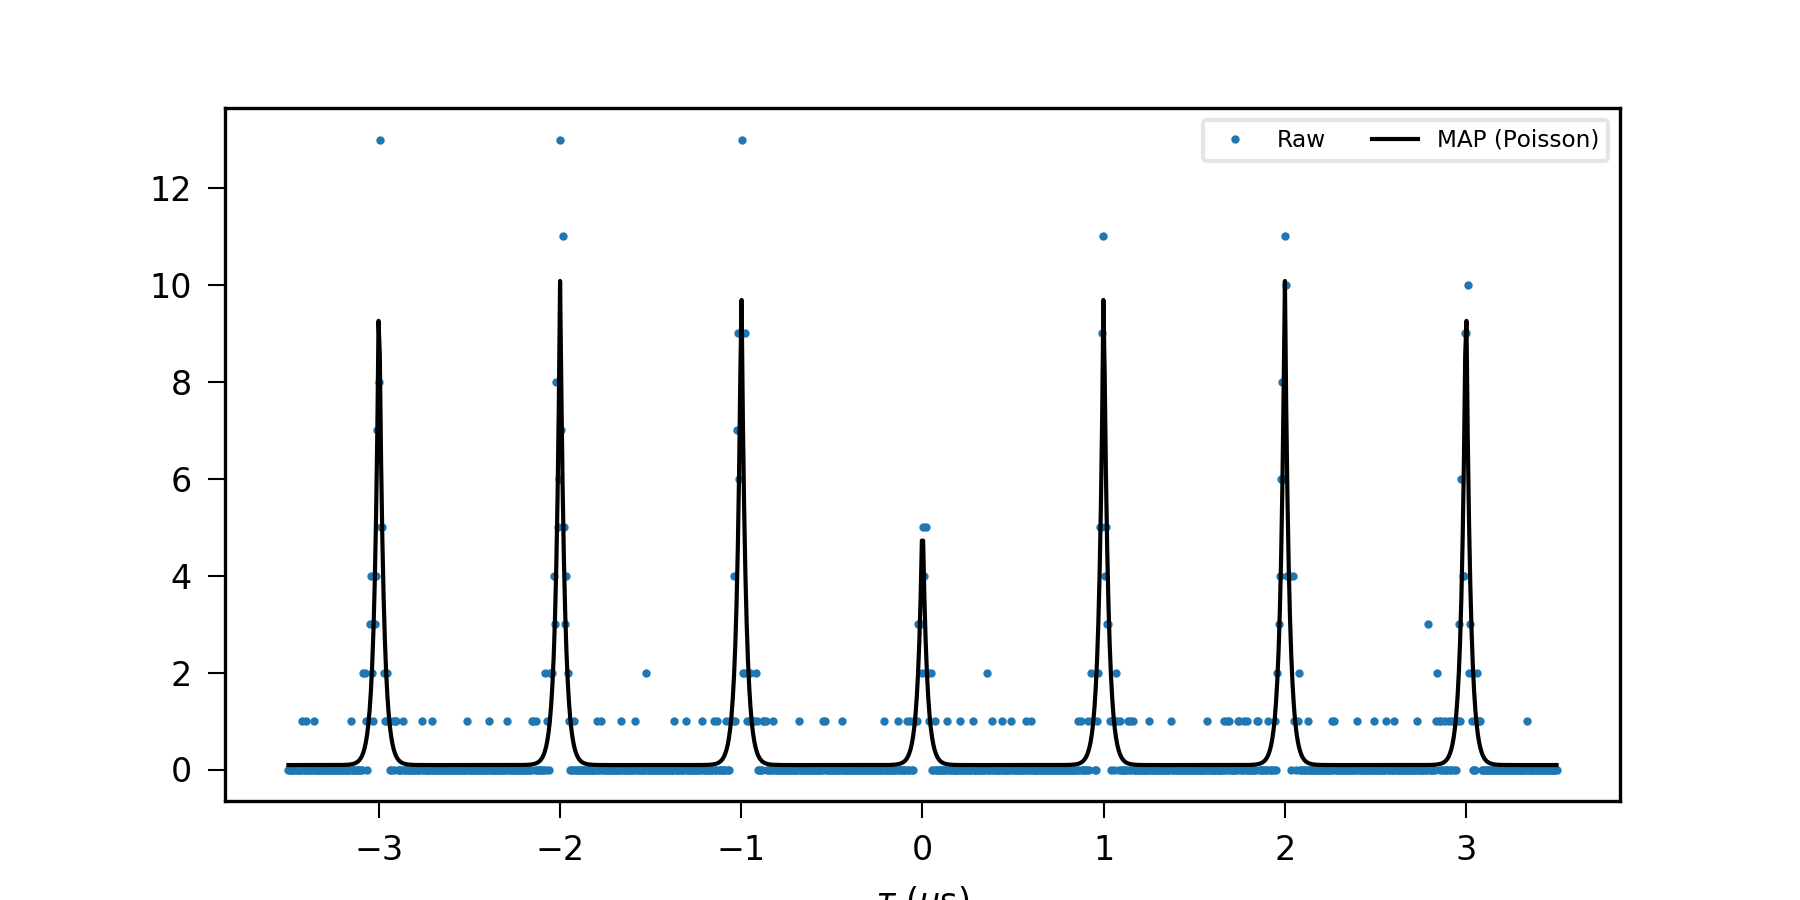

Text(0.5, 0, '$\\tau$ ($\\mu$s)')

In [2]:
funk    = "w[0] + w[1]*np.exp(-np.abs(x)/w[3]) * ( w[2]*np.exp(-np.abs(x)/w[4]) + ( np.exp(-np.abs(x+1*w[5])/w[4]) + np.exp(-np.abs(x-1*w[5])/w[4])) + ( np.exp(-np.abs(x+2*w[5])/w[4]) + np.exp(-np.abs(x-2*w[5])/w[4])) + ( np.exp(-np.abs(x+3*w[5])/w[4]) + np.exp(-np.abs(x-3*w[5])/w[4])))"
funksqr = "w[0]**2 + w[1]**2*np.exp(-np.abs(x)/w[3]**2) * ( w[2]**2*np.exp(-np.abs(x)/w[4]**2) + ( np.exp(-np.abs(x+1*w[5]**2)/w[4]**2) + np.exp(-np.abs(x-1*w[5]**2)/w[4]**2)) + ( np.exp(-np.abs(x+2*w[5]**2)/w[4]**2) + np.exp(-np.abs(x-2*w[5]**2)/w[4]**2)) + ( np.exp(-np.abs(x+3*w[5]**2)/w[4]**2) + np.exp(-np.abs(x-3*w[5]**2)/w[4]**2)))" # squared variables for MAP

integration_time = 10

# Dummy data
xdummy = np.linspace(-3.5,3.5,1000)
w = [0.01, 1, 0.5, 1000, 0.025, 1]
ydummy = g2_func(xdummy, w)
# y = ydummy / np.max(ydummy)
y_pois = MAP.f3Poisson(w, xdummy, integration_time, funk)
y_true = ydummy*integration_time
# ypois = ypois / np.max(ypois)
x = np.array(xdummy)
y = np.array(y_pois)

%matplotlib notebook
fig1 = plt.figure(1, dpi=150,figsize=(6,3))
plt.plot(x,y,'o',markersize=1, label="Raw")
plt.xlabel('$\\tau$ ($\mu$s)')

In [4]:
np.random.seed(12345)

print('Finding MAP...')
thetaFinalP, idxP, thetaFinalL, idxL = MAP.find_MAP(x, y, Nruns=10, Nvars=6, function=funksqr, guess=w, randomizer=0.5)

MAP_fitP = MAP.f2(thetaFinalP[idxP, :], x, funksqr) # Poisson
MAP_fitL = MAP.f2(thetaFinalL[idxL, :], x, funksqr) # Gaussian
w_MAP = thetaFinalP[idxP, :]**2 # best parameters from MAP

# format start point for PyMC
start = {'w0': w_MAP[0],
         'w1': w_MAP[1],
         'w2': w_MAP[2],
         'w3': w_MAP[3],
         'w4': w_MAP[4],
         'w5': w_MAP[5],
         'fit': MAP_fitP}

plt.plot(x,MAP_fitP,color='k',linewidth=1, label="MAP (Poisson)")
plt.legend(loc='best', fontsize='x-small', ncol=2, framealpha=0.5)

  0%|          | 0/10 [00:00<?, ?it/s]

Finding MAP...


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


/Users/andrewproppe/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:470: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Sequential sampling (2 chains in 1 job)
NUTS: [w5, w4, w3, w2, w1, w0]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 46 seconds.


Plotting traces...


<IPython.core.display.Javascript object>


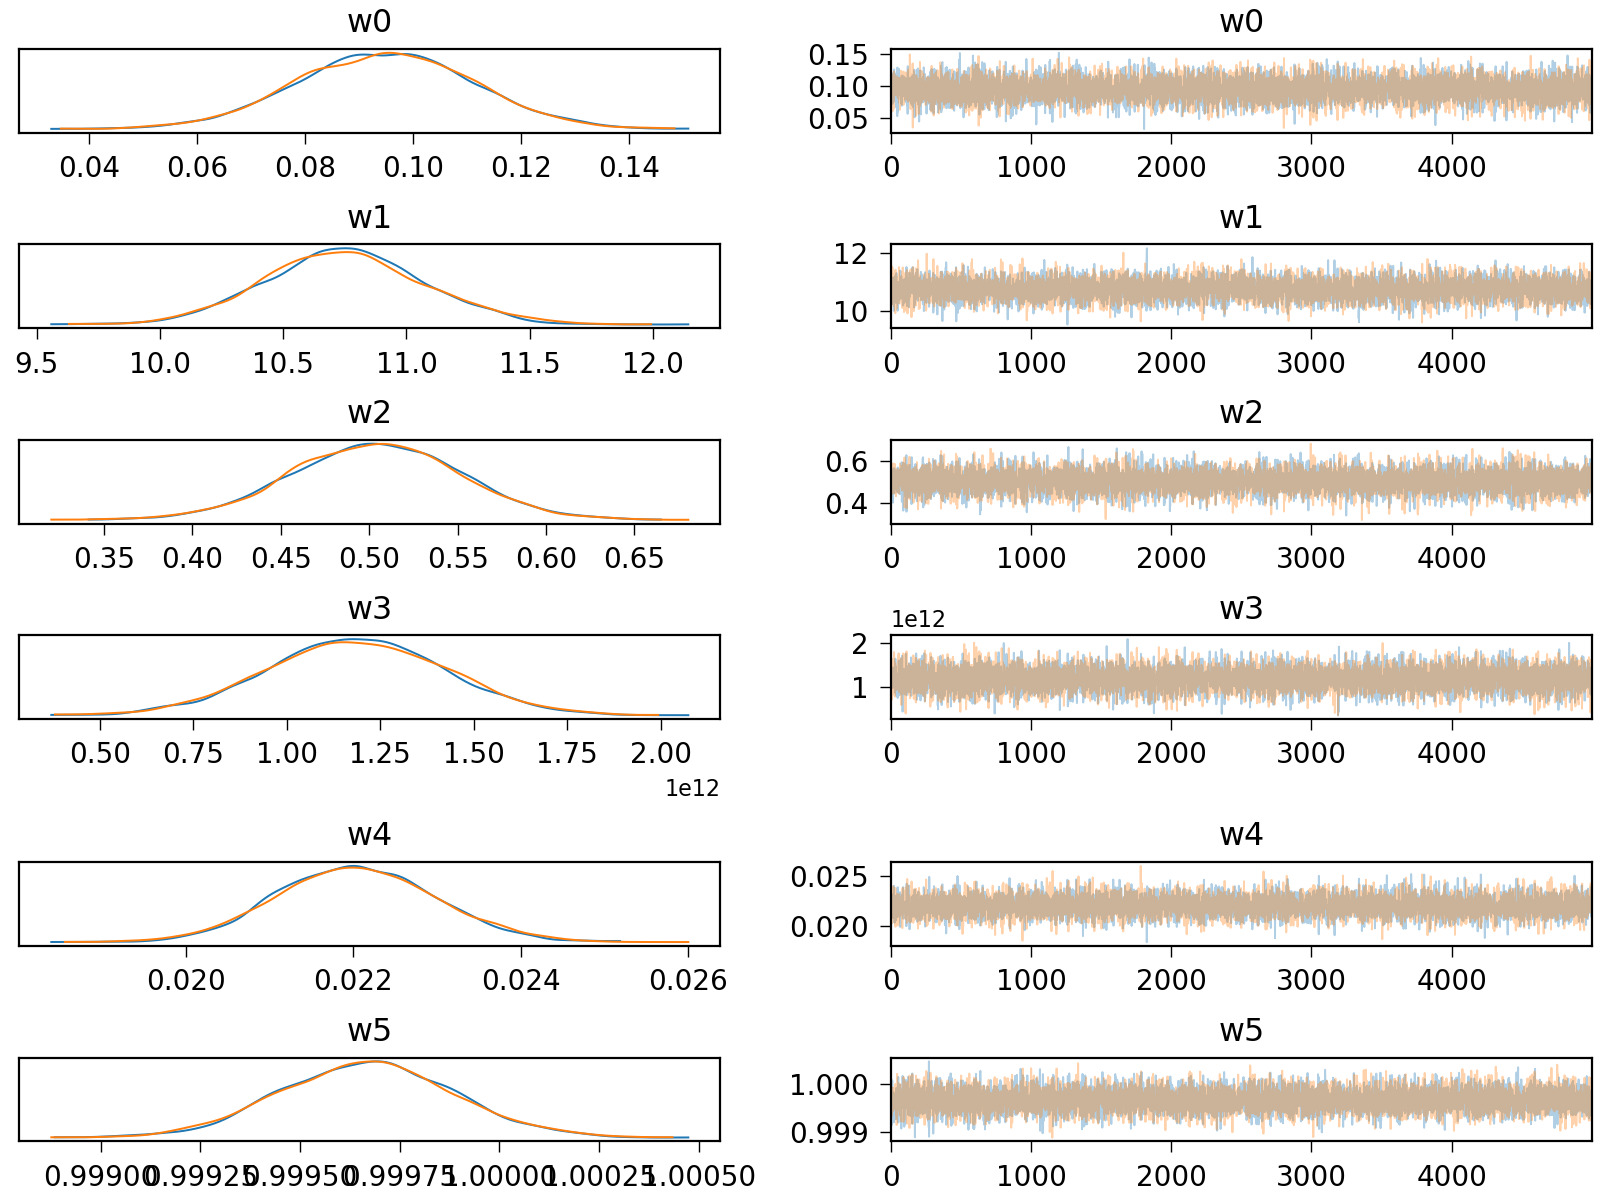

In [5]:
with pm.Model() as model:
    # Use best values from MAP
    w[0] = pm.Normal('w0', mu=w_MAP[0], sigma=w_MAP[0] * 0.2, testval=w_MAP[0])
    w[1] = pm.Normal('w1', mu=w_MAP[1], sigma=w_MAP[1] * 0.2, testval=w_MAP[1])
    w[2] = pm.Normal('w2', mu=w_MAP[2], sigma=w_MAP[2] * 0.2, testval=w_MAP[2])
    w[3] = pm.Normal('w3', mu=w_MAP[3], sigma=w_MAP[3] * 0.2, testval=w_MAP[3])
    w[4] = pm.Normal('w4', mu=w_MAP[4], sigma=w_MAP[4] * 0.2, testval=w_MAP[4])
    w[5] = pm.Normal('w5', mu=w_MAP[5], sigma=w_MAP[5] * 0.02, testval=w_MAP[5])

    fit = pm.Deterministic('fit', eval(funk))

    obs = pm.Normal('obs', mu=fit, observed=y)
    # obs = pm.Poisson('obs', mu=fit, observed=y)

with model:
    # print('Finding MAP...')
    # start=pm.find_MAP(fmin=scipy.optimize.fmin_powell) # The MAP estimate works better here with Powell
    # print('MAP found')
    step = pm.NUTS()
    # step=pm.Metropolis()
    trace = pm.sample(5000, cores=1, step=step, start=start)
#
with model:
    print('Plotting traces...')
    # az.plot_trace(trace, var_names=["c0", "c1", "c2", "t1", "t2", "rr"], figsize=(10,8), divergences='auto')
    az.plot_trace(trace, var_names=["w0", "w1", "w2", "w3", "w4", "w5"], figsize=(8, 6), divergences='auto')

In [ ]:
# with model:
#     print('Displaying summary...')
#     display(az.summary(trace, round_to=2))

In [11]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["w0", "w1", "w2", "w3", "w4", "w5"]
    )

In [ ]:
# az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model)); # (takes very long to plot)

In [12]:
# Mean of posterior sampling for each variable
w_MCMC = np.zeros(6)
w_MCMC[0] = ppc["w0"].mean()
w_MCMC[1] = ppc["w1"].mean()
w_MCMC[2] = ppc["w2"].mean()
w_MCMC[3] = ppc["w3"].mean()
w_MCMC[4] = ppc["w4"].mean()
w_MCMC[5] = ppc["w5"].mean()

y_MCMC = g2_func(x, w_MCMC)

<IPython.core.display.Javascript object>


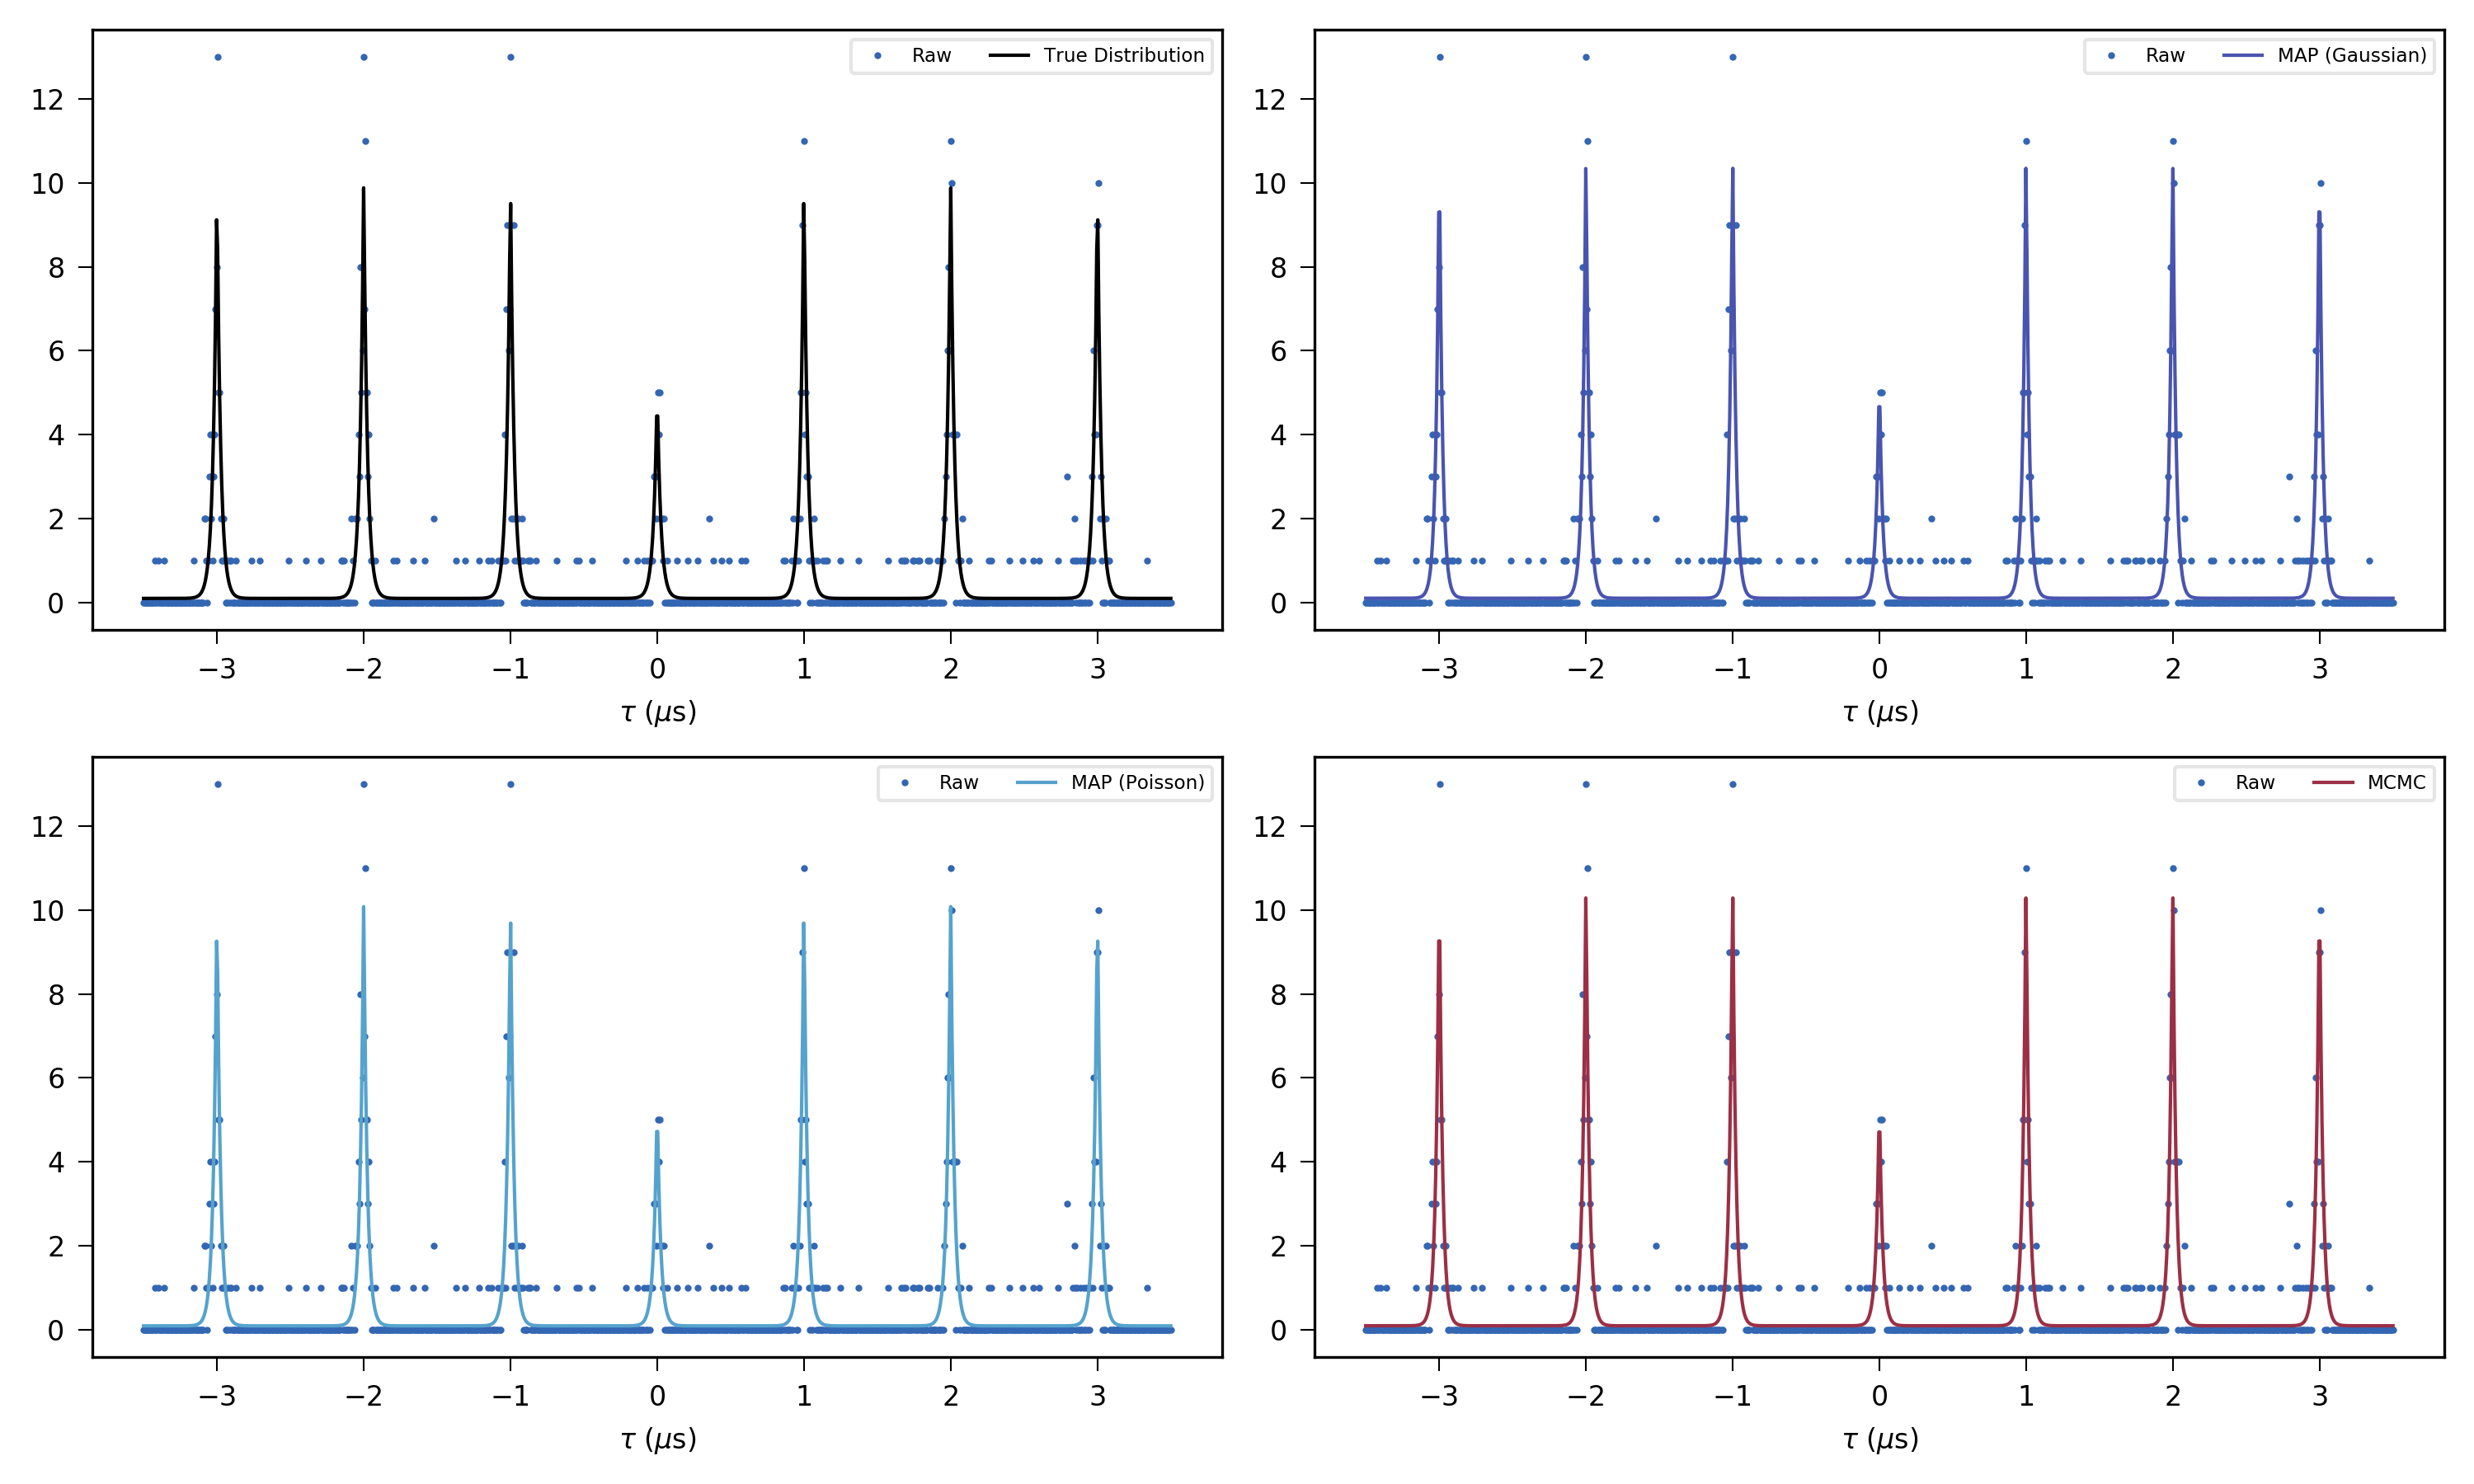

In [13]:
# extract and plot results
y_min = np.percentile(trace.fit, 2.5, axis=0)
y_max = np.percentile(trace.fit, 97.5, axis=0)
y_fit = np.percentile(trace.fit, 50, axis=0)

# Differences between true distribution and fitted functions
diffL = np.sum(np.abs(y_true - MAP_fitL))
diffP = np.sum(np.abs(y_true - MAP_fitP))
diff_MCMC = np.sum(np.abs(y_true - y_MCMC))

fig3 = plt.figure(3, dpi=150,figsize=(10,6))
colors = sns.color_palette("icefire")
spd1 = 2 # subplot dimension 1
spd2 = 2 # subplot dimension 1

ax = plt.subplot(spd1, spd2, 1)
plt.plot(x, y, 'o', color=[0.2, 0.4, 0.7], markersize=1, label='Raw')
plt.plot(x, ydummy*integration_time, color='k', linewidth=1, label='True Distribution') # True Distribution
plt.tight_layout()
plt.xlabel('$\\tau$ ($\mu$s)')
plt.legend(loc='best', fontsize='x-small', ncol=2, framealpha=0.5)

ax = plt.subplot(spd1, spd2, 2)
plt.plot(x, y, 'o', color=[0.2, 0.4, 0.7], markersize=1, label='Raw')
plt.plot(x, MAP.f2(thetaFinalL[idxL, :], x, funksqr), color=colors[1], linewidth=1, label='MAP (Gaussian)') # Recovery (Gaussian)
plt.tight_layout()
plt.xlabel('$\\tau$ ($\mu$s)')
plt.legend(loc='best', fontsize='x-small', ncol=2, framealpha=0.5)

ax = plt.subplot(spd1, spd2, 3)
plt.plot(x, y, 'o', color=[0.2, 0.4, 0.7], markersize=1, label='Raw')
plt.plot(x, MAP.f2(thetaFinalP[idxP, :], x, funksqr), color=colors[0], linewidth=1, label='MAP (Poisson)') # Recovery (Poisson)
plt.xlabel('$\\tau$ ($\mu$s)')
plt.tight_layout()
plt.legend(loc='best', fontsize='x-small', ncol=2, framealpha=0.5)

ax = plt.subplot(spd1, spd2, 4)
plt.plot(x, y, 'o', color=[0.2, 0.4, 0.7], markersize=1, label='Raw')
plt.plot(x, y_MCMC, color=colors[4], linewidth=1, label='MCMC') # MCMC fit
# plt.plot(x, y_fit, color='k', linewidth=1, label='MCMC') # 50th percentile 
plt.tight_layout()
plt.xlabel('$\\tau$ ($\mu$s)')
plt.legend(loc='best', fontsize='x-small', ncol=2, framealpha=0.5)

In [14]:
print('Deviation from true distribution (Poisson loss MAP): %s', diffL)
print('Deviation from true distribution (Gaussian loss MAP): %s', diffP)
print('Deviation from true distribution (MCMC): %s', diff_MCMC)

Deviation from true distribution (Poisson loss MAP): %s 45.2074775104964
Deviation from true distribution (Gaussian loss MAP): %s 28.232372426345307
Deviation from true distribution (MCMC): %s 46.03431957839862
